<a href="https://colab.research.google.com/github/johnerick66/modelo-volatilidad/blob/main/Modelo_Volatilidad_Grupo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [9]:
# Cargar el archivo

url = "https://raw.githubusercontent.com/johnerick66/modelo-volatilidad/main/tipo%20de%20cambio.csv"
# Cargar CSV correctamente interpretando el separador de miles
df = pd.read_csv(
    url,
    sep=",",
    quotechar='"',
    thousands=","
)


In [10]:

# Renombrar columnas a nombres cortos
df = df.rename(columns={
    "Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Venta": "TC",
    "dia": "dia",
    "mes": "mes",
    "año": "anio",
    "fecha": "fecha",
    "dia de semana": "dia_semana",
    "Inflación PERU": "inflacion_peru",
    "Precio Cobre": "precio_cobre",
    "Precio Oro": "precio_oro",
    "Precio Zinc": "precio_zinc",
    "PIB": "pbi",
    "Reservas internacionales": "reservas",
    "Intervenciones del BCRP": "interv_bcrp",
    "Inflación EEUU": "inflacion_usa"
})

In [11]:
#Correccion de columnas

# Limpiar porcentaje
df["inflacion_usa"] = (
    df["inflacion_usa"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .astype(float) / 100
)


In [12]:


print("--- PREVIEW DEL DATASET ---")
print(df.head())
print("Shape:", df.shape)

--- PREVIEW DEL DATASET ---
      TC  dia  mes  anio       fecha  dia_semana  inflacion_peru precio_cobre  \
0  2.989    1  Ene  2015  01/01/2015           4            3.07       265.58   
1  2.989    2  Ene  2015  02/01/2015           5            3.07       265.58   
2  2.992    5  Ene  2015  05/01/2015           1            3.07       265.58   
3  2.983    6  Ene  2015  06/01/2015           2            3.07       265.58   
4  2.987    7  Ene  2015  07/01/2015           3            3.07       265.58   

  precio_oro precio_zinc     pbi     reservas  interv_bcrp  inflacion_usa  
0   1,249.45       95.96  442.23  62086.34977            1         0.0025  
1   1,249.45       95.96  442.23  62086.34977            1         0.0025  
2   1,249.45       95.96  442.23  62086.34977            1         0.0025  
3   1,249.45       95.96  442.23  62416.87961            1         0.0025  
4   1,249.45       95.96  442.23  62367.97035            1         0.0025  
Shape: (2851, 14)


In [13]:
# Nombre de la columna de tipo de cambio (target base)
tc_col = 'TC'

# 1.1 ANÁLISIS EXPLORATORIO DE DATOS

In [14]:

print("\n========================")
print("1.1 ANÁLISIS EXPLORATORIO")
print("========================")



1.1 ANÁLISIS EXPLORATORIO


In [15]:
# a) ¿Cuántas filas y columnas tiene?
filas, cols = df.shape
print(f"\na) El dataset tiene {filas} filas y {cols} columnas.")


a) El dataset tiene 2851 filas y 14 columnas.


In [16]:
# b) ¿Cuál es el target?
print(f"\nb) Nuestro target base es la columna:\n   '{tc_col}'")
print("   (tipo de cambio de venta, sobre el cual luego construimos los rendimientos logarítmicos).")



b) Nuestro target base es la columna:
   'TC'
   (tipo de cambio de venta, sobre el cual luego construimos los rendimientos logarítmicos).



c) Balance del target:
   El target es numérico continuo, por lo que NO hablamos de clases balanceadas,
   sino de la distribución de valores. Mostramos un histograma:


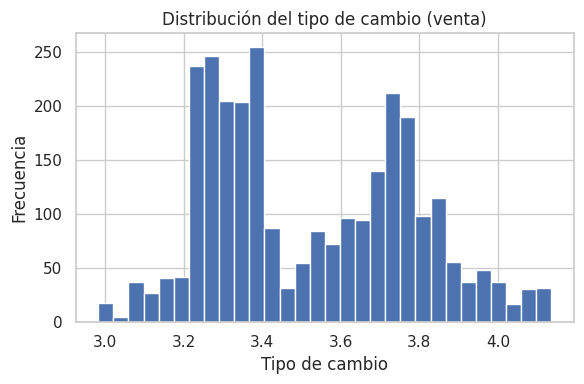

In [17]:
# c) ¿Las etiquetas del target están balanceadas?
print("\nc) Balance del target:")
if pd.api.types.is_numeric_dtype(df[tc_col]) and df[tc_col].nunique() > 20:
    print("   El target es numérico continuo, por lo que NO hablamos de clases balanceadas,")
    print("   sino de la distribución de valores. Mostramos un histograma:")
    plt.figure(figsize=(6,4))
    df[tc_col].hist(bins=30)
    plt.title('Distribución del tipo de cambio (venta)')
    plt.xlabel('Tipo de cambio')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
else:
    conteo = df[tc_col].value_counts()
    porcentaje = df[tc_col].value_counts(normalize=True) * 100
    print("Conteo por clase:\n", conteo)
    print("\nPorcentaje por clase (%):\n", porcentaje.round(2))
    plt.figure(figsize=(6,4))
    conteo.plot(kind='bar')
    plt.title('Distribución de clases del target')
    plt.xlabel('Clases')
    plt.ylabel('Número de registros')
    plt.tight_layout()
    plt.show()



d) Datos faltantes por columna:
TC                 0
dia                0
mes                0
anio               0
fecha              0
dia_semana         0
inflacion_peru    11
precio_cobre      11
precio_oro        11
precio_zinc       11
pbi                0
reservas           0
interv_bcrp        0
inflacion_usa      0
dtype: int64

Porcentaje de datos faltantes (%):
TC                0.0000
dia               0.0000
mes               0.0000
anio              0.0000
fecha             0.0000
dia_semana        0.0000
inflacion_peru    0.3858
precio_cobre      0.3858
precio_oro        0.3858
precio_zinc       0.3858
pbi               0.0000
reservas          0.0000
interv_bcrp       0.0000
inflacion_usa     0.0000
dtype: float64


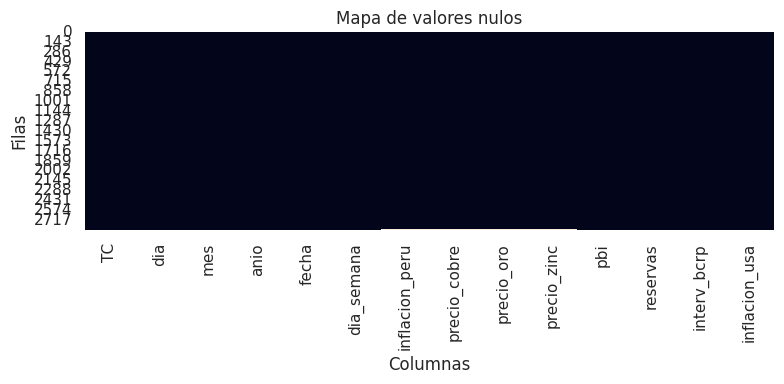

In [18]:
# d) ¿Hay datos faltantes?
print("\nd) Datos faltantes por columna:")
print(df.isnull().sum())

print("\nPorcentaje de datos faltantes (%):")
print((df.isnull().mean() * 100).round(4))

plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Mapa de valores nulos')
plt.xlabel('Columnas')
plt.ylabel('Filas')
plt.tight_layout()
plt.show()


In [19]:
# e) ¿Hay datos fuera de serie? (outliers)
print("\ne) Detección de outliers con IQR:")

numeric_df = df.select_dtypes(include='number')
num_cols = numeric_df.columns.tolist()
print("Columnas numéricas:", num_cols)

for col in num_cols:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)]
    print(f"   - {col}: {outliers.shape[0]} outliers")


e) Detección de outliers con IQR:
Columnas numéricas: ['TC', 'dia', 'anio', 'dia_semana', 'inflacion_peru', 'pbi', 'reservas', 'interv_bcrp', 'inflacion_usa']
   - TC: 0 outliers
   - dia: 0 outliers
   - anio: 0 outliers
   - dia_semana: 0 outliers
   - inflacion_peru: 304 outliers
   - pbi: 43 outliers
   - reservas: 0 outliers
   - interv_bcrp: 0 outliers
   - inflacion_usa: 0 outliers


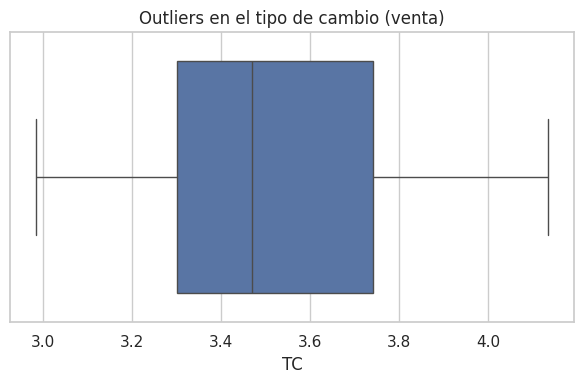

In [20]:
# Boxplot solo del tipo de cambio
plt.figure(figsize=(6,4))
sns.boxplot(x=df[tc_col])
plt.title('Outliers en el tipo de cambio (venta)')
plt.tight_layout()
plt.show()

In [21]:
# f) ¿Qué tipos de datos son? (numéricos, ordinales, etc.)
print("\nf) Tipos de datos por columna:")
print(df.dtypes)

print("\nColumnas numéricas:", numeric_df.columns.tolist())
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas categóricas / texto:", cat_cols)


f) Tipos de datos por columna:
TC                float64
dia                 int64
mes                object
anio                int64
fecha              object
dia_semana          int64
inflacion_peru    float64
precio_cobre       object
precio_oro         object
precio_zinc        object
pbi               float64
reservas          float64
interv_bcrp         int64
inflacion_usa     float64
dtype: object

Columnas numéricas: ['TC', 'dia', 'anio', 'dia_semana', 'inflacion_peru', 'pbi', 'reservas', 'interv_bcrp', 'inflacion_usa']
Columnas categóricas / texto: ['mes', 'fecha', 'precio_cobre', 'precio_oro', 'precio_zinc']




g) Correlación entre variables numéricas:
                      TC       dia      anio  dia_semana  inflacion_peru  \
TC              1.000000 -0.001812  0.748187   -0.006519        0.516987   
dia            -0.001812  1.000000  0.003030    0.002930        0.001816   
anio            0.748187  0.003030  1.000000    0.005305        0.156310   
dia_semana     -0.006519  0.002930  0.005305    1.000000        0.000729   
inflacion_peru  0.516987  0.001816  0.156310    0.000729        1.000000   
pbi             0.527608  0.013953  0.642676    0.006493        0.129311   
reservas        0.703073  0.005045  0.905587    0.010308        0.131409   
interv_bcrp    -0.012682  0.003126  0.015616    0.014041       -0.017686   
inflacion_usa   0.382156  0.005160  0.743440    0.004440        0.095462   

                     pbi  reservas  interv_bcrp  inflacion_usa  
TC              0.527608  0.703073    -0.012682       0.382156  
dia             0.013953  0.005045     0.003126       0.005160  


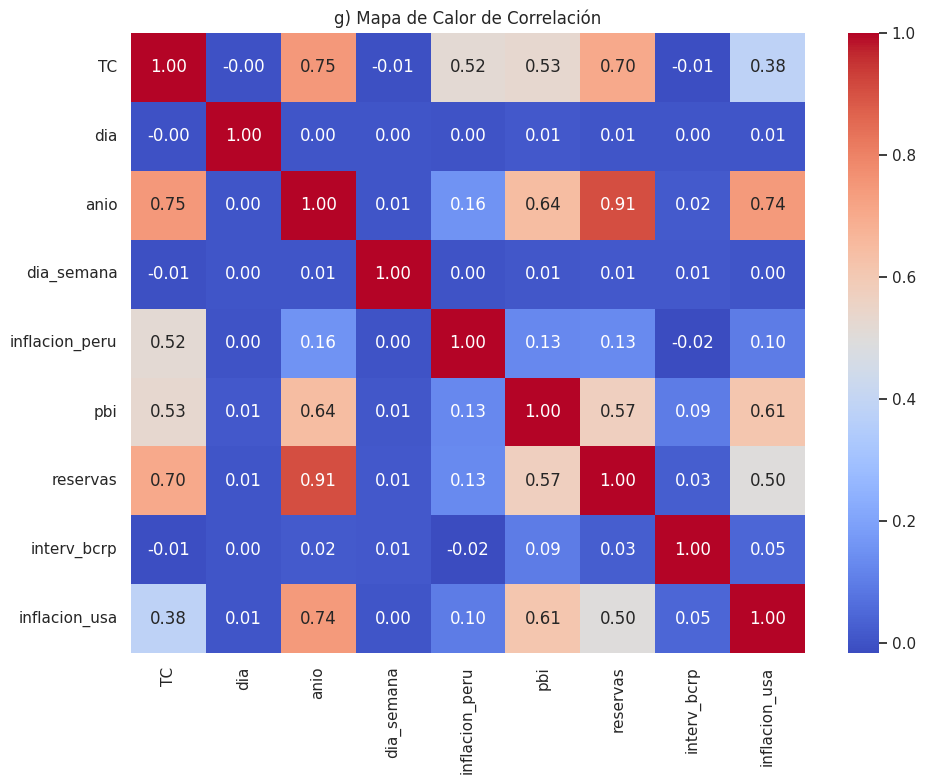

In [22]:
# g) ¿Hay correlación entre los datos?
print("\n\ng) Correlación entre variables numéricas:")

corr = numeric_df.corr()
print(corr)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('g) Mapa de Calor de Correlación')
plt.tight_layout()
plt.show()


# 1.2 PROCESAMIENTO DE DATOS

In [23]:
print("\n========================")
print("1.2 PROCESAMIENTO DE DATOS")
print("========================")

df_proc = df.copy()


1.2 PROCESAMIENTO DE DATOS


In [24]:
# 1) Ajuste de tipos: convertir 'fecha' a datetime y usarla como índice temporal
df_proc['fecha'] = pd.to_datetime(df_proc['fecha'], format='%d/%m/%Y', errors='coerce')
df_proc = df_proc.set_index('fecha').sort_index()
print("-> 'fecha' convertida a datetime y establecida como índice temporal.")

-> 'fecha' convertida a datetime y establecida como índice temporal.


In [25]:
# 2) Creación del Target de Volatilidad: rendimientos logarítmicos del tipo de cambio de venta
df_proc['Rendimientos_log'] = np.log(df_proc[tc_col] / df_proc[tc_col].shift(1))
df_proc.dropna(subset=['Rendimientos_log'], inplace=True)
print("-> Target 'Rendimientos_log' creado correctamente (log(TC_t / TC_{t-1})).")

print("\nPreview con rendimientos:")
print(df_proc[[tc_col, 'Rendimientos_log']].head())

-> Target 'Rendimientos_log' creado correctamente (log(TC_t / TC_{t-1})).

Preview con rendimientos:
               TC  Rendimientos_log
fecha                              
2015-01-02  2.989          0.000000
2015-01-05  2.992          0.001003
2015-01-06  2.983         -0.003013
2015-01-07  2.987          0.001340
2015-01-08  2.989          0.000669


In [26]:
# 3) Escalado de variables numéricas para modelos posteriores (Agregado)
from sklearn.preprocessing import MinMaxScaler

feature_cols = [c for c in df_proc.select_dtypes(include='number').columns
                if c != 'Rendimientos_log']

scaler = MinMaxScaler()
df_scaled = df_proc.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

print("\n-> Se generó 'df_scaled' con las variables numéricas escaladas entre 0 y 1 (excepto el target).")
print("Shape df_proc:", df_proc.shape)
print("Shape df_scaled:", df_scaled.shape)


-> Se generó 'df_scaled' con las variables numéricas escaladas entre 0 y 1 (excepto el target).
Shape df_proc: (2850, 14)
Shape df_scaled: (2850, 14)


##Avance para el dia jueves, Borrador


=== 2.0 Definición de X e y ===
Features usadas: ['TC', 'dia', 'anio', 'dia_semana', 'inflacion_peru', 'pbi', 'reservas', 'interv_bcrp', 'inflacion_usa']
Shape X: (2850, 9) Shape y: (2850,)
Train: (2280, 9) Test: (570, 9)

=== 2.1.a Uso de LazyPredict (LazyRegressor) ===
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 2280, number of used features: 9
[LightGBM] [Info] Start training from score 0.000106

Ranking de modelos (top 10):
                             Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                       
OrthogonalMatchingPursuitCV               -0.01       0.01  0.00        0.02
OrthogonalMatchingPursuit                 -0.01       0.01  0.00        0.02
LassoLarsIC                               -0.01       0.01  0.00        0.01
TweedieRegressor                          -0.01       0.00  0.00        0.02
LarsCV                                    -0.02       0.00  0.00        0.03
LassoLarsCV                 

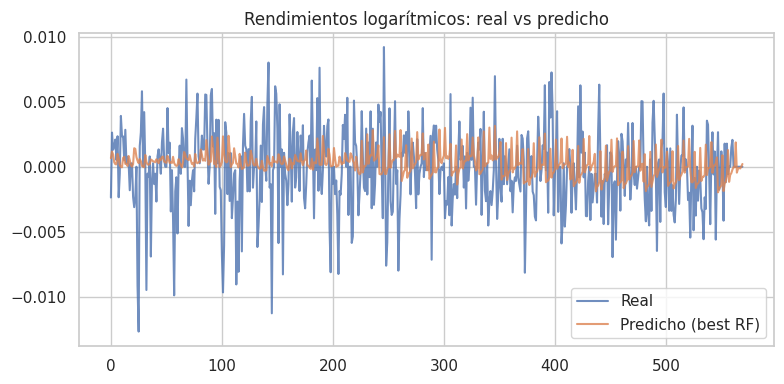


=== 2.2 Guardar el mejor modelo ===
Modelo guardado como 'mejor_modelo_rf_tc.pkl'


In [27]:
# ======================================================
# 2. EXPLORACIÓN DE MODELOS (JUEVES) - REGRESIÓN
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

sns.set(style="whitegrid")

# ======================================================
# 2.0. DEFINICIÓN DE FEATURES Y TARGET
#     Usamos df_scaled del bloque anterior
# ======================================================

print("\n=== 2.0 Definición de X e y ===")

# Columnas numéricas que NO son el target (ya escaladas en df_scaled)
feature_cols = [c for c in df_scaled.select_dtypes(include='number').columns
                if c != 'Rendimientos_log']

X = df_scaled[feature_cols]
y = df_scaled['Rendimientos_log']

print("Features usadas:", feature_cols)
print("Shape X:", X.shape, "Shape y:", y.shape)

# Split respetando el orden temporal (no mezclamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# ======================================================
# 2.1.a USO DE LAZYPREDICT (LazyRegressor)
# ======================================================

print("\n=== 2.1.a Uso de LazyPredict (LazyRegressor) ===")

!pip install -q lazypredict

from lazypredict.Supervised import LazyRegressor

lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)

# Ordenamos por R2 descendente (entre más alto mejor)
models_sorted = models.sort_values(by="R-Squared", ascending=False)
print("\nRanking de modelos (top 10):")
print(models_sorted.head(10))

# ======================================================
# 2.1.b SELECCIÓN DE 1 MODELO Y NUEVO ENTRENAMIENTO
#     (Tomamos RandomForestRegressor, que suele estar arriba)
# ======================================================

print("\n=== 2.1.b Selección y nuevo entrenamiento ===")

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_base = rf.predict(X_test)

print("Métricas modelo base (RandomForestRegressor con hiperparámetros por defecto extendidos):")
print("  MAE   :", mean_absolute_error(y_test, y_pred_base))
print("  RMSE  :", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("  R2    :", r2_score(y_test, y_pred_base))

# ======================================================
# 2.1.c OPTIMIZACIÓN DE HIPERPARÁMETROS CON CV=5
#     Usamos GridSearchCV
# ======================================================

print("\n=== 2.1.c Optimización de hiperparámetros (CV=5) ===")

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

# ======================================================
# 2.1.d ANÁLISIS DE MÉTRICAS DEL MEJOR MODELO
# ======================================================

print("\n=== 2.1.d Métricas del mejor modelo (RandomForest optimizado) ===")

y_pred_best = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("  MAE   :", mae)
print("  RMSE  :", rmse)
print("  R2    :", r2)

# Comparación rápida vs modelo base
print("\nComparación vs modelo base:")
print("  Mejora MAE  :", mean_absolute_error(y_test, y_pred_base) - mae)
print("  Mejora RMSE :", np.sqrt(mean_squared_error(y_test, y_pred_base)) - rmse)
print("  Mejora R2   :", r2 - r2_score(y_test, y_pred_base))

# (Opcional) gráfico de y real vs predicho
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='Real', alpha=0.8)
plt.plot(y_pred_best, label='Predicho (best RF)', alpha=0.8)
plt.title('Rendimientos logarítmicos: real vs predicho')
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 2.2 GUARDAR EL MEJOR MODELO
# ======================================================

print("\n=== 2.2 Guardar el mejor modelo ===")

joblib.dump(best_rf, 'mejor_modelo_rf_tc.pkl')
print("Modelo guardado como 'mejor_modelo_rf_tc.pkl'")

# En Colab, para descargar:
# from google.colab import files
# files.download('mejor_modelo_rf_tc.pkl')


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Modelo base
lr = LinearRegression()

# ===== FORWARD: SOLO 3 VARIABLES =====
sfs_3 = SequentialFeatureSelector(
    lr,
    n_features_to_select=3,   # 👈 Aquí lo obligamos a elegir solo 3
    direction="forward",
    scoring="r2",
    cv=5,                     # puedes usar TimeSeriesSplit si quieres ser más fino
    n_jobs=-1
)

print("=== Entrenando selección forward (k = 3) ===")
sfs_3.fit(X_train, y_train)

# Columnas seleccionadas
selected_cols = X_train.columns[sfs_3.get_support()]
print("\nVariables seleccionadas (k = 3):")
for c in selected_cols:
    print(" -", c)

# ===== Entrenamos el modelo solo con esas 3 =====
X_train_sel = X_train[selected_cols]
X_test_sel  = X_test[selected_cols]

# Imputar posibles NaN
imputer = SimpleImputer(strategy="median")
X_train_sel_imp = imputer.fit_transform(X_train_sel)
X_test_sel_imp  = imputer.transform(X_test_sel)

lr.fit(X_train_sel_imp, y_train)
y_pred = lr.predict(X_test_sel_imp)

r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nMétricas modelo lineal con 3 variables (forward):")
print(f"  R2   : {r2:.4f}")
print(f"  MAE  : {mae:.6f}")
print(f"  RMSE : {rmse:.6f}")





=== Entrenando selección forward (k = 3) ===

Variables seleccionadas (k = 3):
 - dia_semana
 - pbi
 - interv_bcrp

Métricas modelo lineal con 3 variables (forward):
  R2   : 0.0091
  MAE  : 0.002324
  RMSE : 0.003095
